# Online Sales Intention Prediction

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly
from sklearn.cluster import KMeans
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, classification_report,confusion_matrix,accuracy_score,precision_score,recall_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import warnings
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import time

In [0]:
df = pd.read_csv('online_shoppers_intention.csv')

In [6]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Looking for missing data points.

In [7]:
df.isna().sum()/len(df)

Administrative             0.0
Administrative_Duration    0.0
Informational              0.0
Informational_Duration     0.0
ProductRelated             0.0
ProductRelated_Duration    0.0
BounceRates                0.0
ExitRates                  0.0
PageValues                 0.0
SpecialDay                 0.0
Month                      0.0
OperatingSystems           0.0
Browser                    0.0
Region                     0.0
TrafficType                0.0
VisitorType                0.0
Weekend                    0.0
Revenue                    0.0
dtype: float64

In [8]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


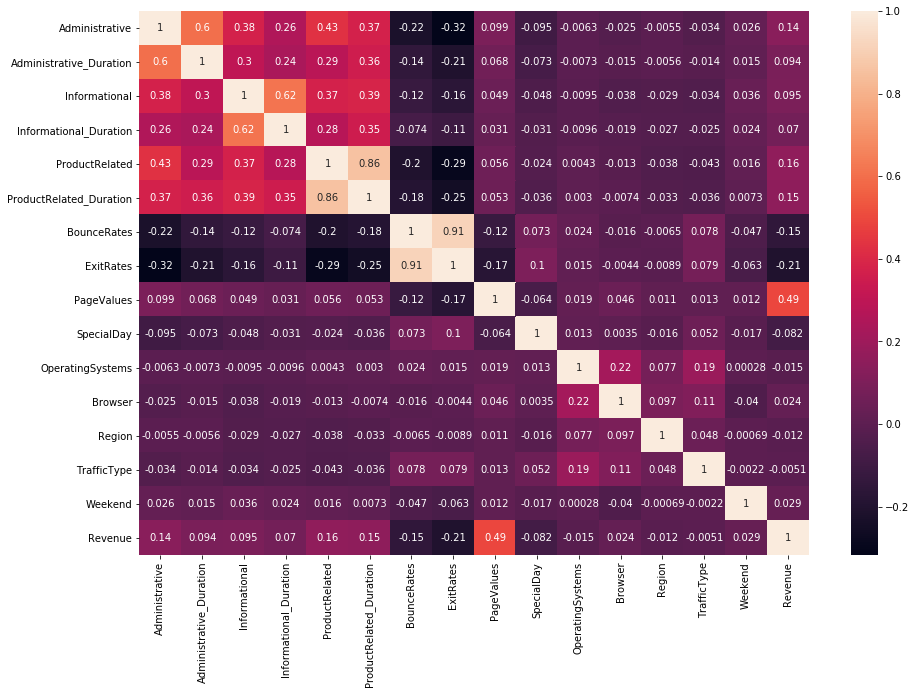

In [9]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)

Correlation observations:



*   Revenue and PageValues are greatly correlated.
*   BounceRates and ExitRates are negatively correlated with PageValues. This means that reducing BounceRates and ExitRates on our webpage could lead to more revenue.



In [10]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [11]:
df.loc[df['Revenue']==True]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
65,3,87.833333,0,0.00,27,798.333333,0.000000,0.012644,22.916036,0.8,Feb,2,2,3,1,Returning_Visitor,False,True
76,10,1005.666667,0,0.00,36,2111.341667,0.004348,0.014493,11.439412,0.0,Feb,2,6,1,2,Returning_Visitor,False,True
101,4,61.000000,0,0.00,19,607.000000,0.000000,0.026984,17.535959,1.0,Feb,1,1,7,4,Returning_Visitor,True,True
188,9,111.500000,1,48.50,49,1868.819697,0.000000,0.020709,1.706015,0.0,Mar,2,2,7,2,Returning_Visitor,False,True
196,2,56.000000,1,144.00,67,2563.783333,0.000000,0.005797,19.342650,0.0,Mar,2,2,4,2,New_Visitor,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12272,6,133.466667,0,0.00,44,2664.445833,0.002041,0.010884,97.860836,0.0,Nov,2,2,1,3,Returning_Visitor,True,True
12276,7,139.575000,0,0.00,30,986.500000,0.000000,0.011429,36.392861,0.0,Dec,2,10,1,2,New_Visitor,False,True
12311,1,0.000000,2,211.25,144,4627.489571,0.001361,0.020664,0.000000,0.0,Nov,2,2,1,2,Returning_Visitor,False,True
12312,7,150.357143,1,9.00,221,11431.001240,0.011149,0.021904,1.582473,0.0,Nov,2,5,1,2,Returning_Visitor,True,True


In [12]:
df.loc[df['Revenue']==False]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


## Exploratory Data Analysis

In [13]:
fig = go.Figure([go.Pie(labels=df['Revenue'].unique(),values=df['Revenue'].value_counts())])
fig.update_layout(title_text = "Total Sales Conversion Rate",title_x =0.5)
fig.show()

Only 15.5% of total visits to this e-commerce site have led to a sale. 

In [14]:
fig = go.Figure([go.Bar(x=df.groupby('Month').count().index.values,y=df.loc[df['Revenue']==True].groupby('Month').count()['Revenue'])])
fig.update_layout(title_text = "Sales made per Month",title_x =0.5)
fig.show()

We observe most sales take place in November possibly because of early Christmas shopping, Thanksgiving and Black Friday Sales.


In [15]:
fig = plotly.subplots.make_subplots(rows=1,cols=2,vertical_spacing=0.09,subplot_titles=["Sales Made During The Weekend","Sales Made Per Region"])

fig.add_trace(go.Bar(x=df.groupby('Weekend').count().index.values,y=df.loc[df['Revenue']==True].groupby('Weekend').count()['Revenue'],text=df.loc[df['Revenue']==True].groupby('Weekend').count()['Revenue'],textposition="outside",name="Weekend"))

fig.add_trace(go.Bar(x=df.groupby('Region').count().index.values,y=df.loc[df['Revenue']==True].groupby('Region').count()['Revenue'],text=df.loc[df['Revenue']==True].groupby('Region').count()['Revenue'],textposition='outside',name="Region"),row=1,col=2)

fig.show()

A majority of sales are from regions 1,2 and 3. 

Perhaps it is better to focus marketing campaigns specifically in these areas.

In [16]:
fig = plotly.subplots.make_subplots(rows=1,cols=1,vertical_spacing=0.09,subplot_titles=["Sales per Visitor Type"])

fig.add_trace(go.Bar(x=df.groupby('VisitorType').count().index.values,y=df.loc[df['Revenue']==True].groupby('VisitorType').count()['Revenue'],text=df.loc[df['Revenue']==True].groupby('VisitorType').count()['Revenue'],textposition="outside",name="Sale Made"))

fig.add_trace(go.Bar(x=df.groupby('VisitorType').count().index.values,y=df.loc[df['Revenue']==False].groupby('VisitorType').count()['Revenue'],text=df.loc[df['Revenue']==False].groupby('VisitorType').count()['Revenue'],textposition='outside',name="Sale Not Made"),row=1,col=1)

fig.show()

Most sales were made by returning vistors but new visitors had more potential to make a sale because almost 33% of them bought an item during their first visit.

In [17]:
fig = go.Figure([go.Pie(labels=df.groupby('Month').count().index.values,values=df.loc[df['Revenue']==True].groupby('Month').count()['SpecialDay'])])
#fig.update_layout(title_text = "Sales made per Month",title_x =0.5)
fig.show()

SpecialDays such as Valentine's Day etc have not affected sales for this e-commerce company.

In [0]:
high_page_val = df.loc[df['PageValues']>55]
#high_page_val = df

In [19]:
fig = go.Figure([go.Pie(labels=high_page_val['Revenue'].unique(),values=high_page_val['Revenue'].value_counts())])
fig.update_layout(title_text = "Total Sales Conversion Rate for High Page Values",title_x =0.5)
fig.show()

80% of shoppers with high page values ended up buying a product.

Which pages did these customers spend more time on?

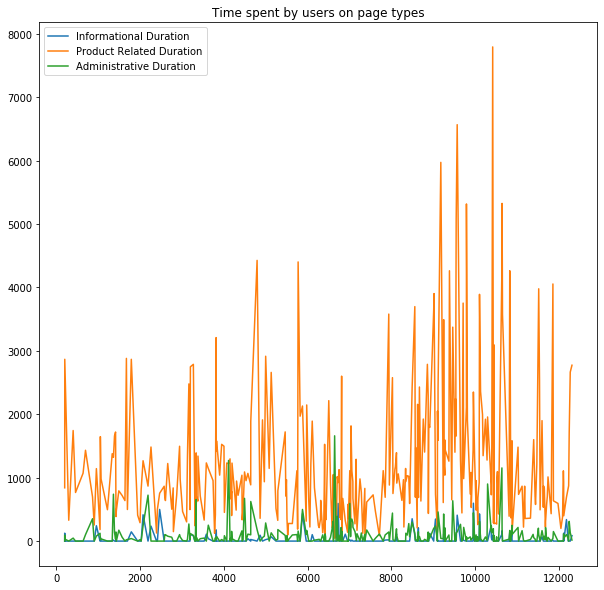

In [20]:
#high_page_val = high_page_val.loc[high_page_val['Revenue']==False]
plt.figure(figsize=(10,10))
plt.plot(high_page_val['Informational_Duration'],label="Informational Duration")
plt.plot(high_page_val['ProductRelated_Duration'],label="Product Related Duration")
plt.plot(high_page_val['Administrative_Duration'],label="Administrative Duration")
plt.title("Time spent by users on page types")
plt.legend()

Keeping users engaged in ProductRelated pages for longer leads to more PageValues and sales.

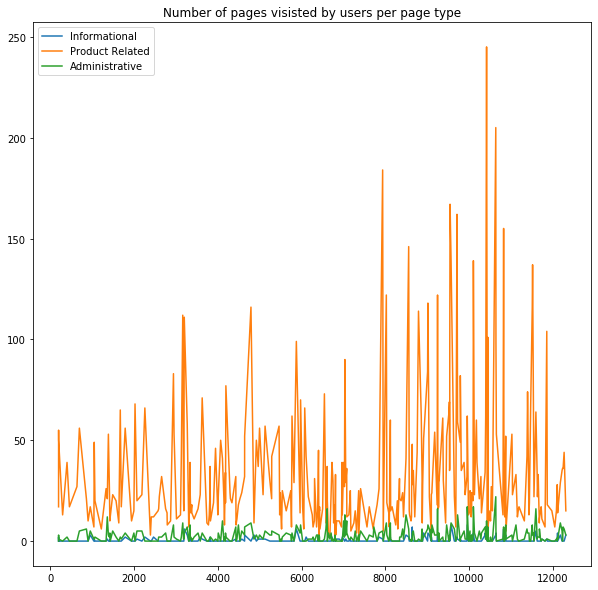

In [21]:
plt.figure(figsize=(10,10))
plt.plot(high_page_val['Informational'],label="Informational")
plt.plot(high_page_val['ProductRelated'],label="Product Related")
plt.plot(high_page_val['Administrative'],label="Administrative")
plt.title("Number of pages visisted by users per page type")

plt.legend()

Users who viewed more product related pages ended up buying a product.

In [194]:
fig = go.Figure([go.Pie(labels=high_page_val[['Administrative','ProductRelated','Informational']].columns,values=high_page_val[['Administrative','ProductRelated','Informational']].sum())])
fig.update_layout(title_text = "Number of Highly Valuable Pages per Page Type",title_x =0.5)
fig.show()

ProductRelated Pages are highly valuable and lead to the most sales.

#### Exit Rates vs Bounce Rates

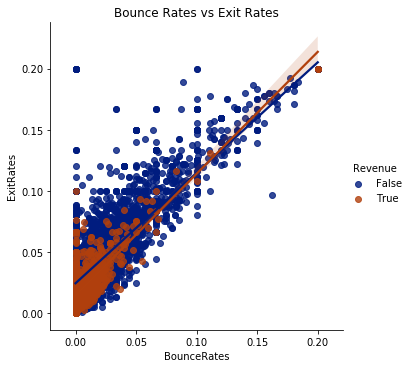

In [0]:
sns.lmplot(y='ExitRates',x='BounceRates',data=df,hue='Revenue',palette='dark').set(title="Bounce Rates vs Exit Rates")

Exit Rates and Bounce Rates have a linear relationship. Sessions with low bounce/exit rates will mostly end in a sale.

We observe that most sales are made when bounce rate and exit rates are low.

In [0]:
fig = plotly.subplots.make_subplots(rows=1,cols=1,vertical_spacing=0.09,subplot_titles=["Sales per Traffic Type"])

fig.add_trace(go.Bar(x=df.groupby('TrafficType').count().index.values,y=df.loc[df['Revenue']==True].groupby('TrafficType').count()['Revenue'],text=df.loc[df['Revenue']==True].groupby('TrafficType').count()['Revenue'],textposition="outside",name="Sale Made"))

fig.add_trace(go.Bar(x=df.groupby('TrafficType').count().index.values,y=df.loc[df['Revenue']==False].groupby('TrafficType').count()['Revenue'],text=df.loc[df['Revenue']==False].groupby('TrafficType').count()['Revenue'],textposition='outside',name="Sale Not Made"),row=1,col=1)

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        #tick0 = 0.5,
        #dtick = 0.75
    )
)

fig.show()

Most visitors arrived from traffic types 1,2,3 and 4. With more sales coming from these traffic types. Increasing marketting efforts for these traffic types would greatly boost sales.

### Cluster Analysis

#### Administrative Duration vs Bounce Rates Clustering

Elbow method to find the best value of K

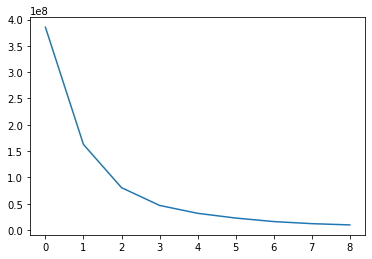

In [168]:
elb_list = []
for k in range(1,10):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(df[['BounceRates','Administrative_Duration']])
  elb_list.append(kmeans.inertia_)

plt.plot(elb_list)


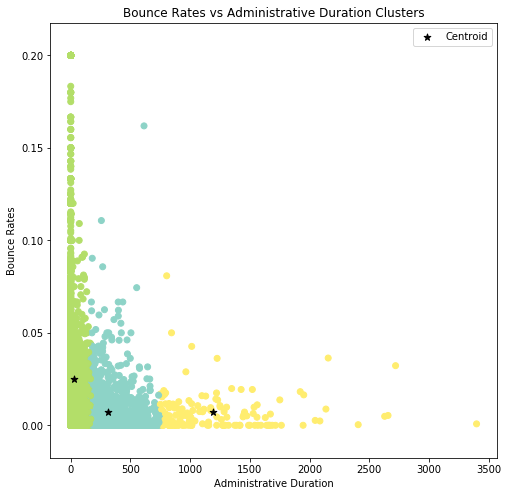

In [174]:
df_cluster = df[['Administrative_Duration','BounceRates']].to_numpy()
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['BounceRates','Administrative_Duration']])
y_kmeans = kmeans.predict(df[['BounceRates','Administrative_Duration']])
plt.figure(figsize=(8,8))
plt.scatter(df['Administrative_Duration'],df['BounceRates'], c=y_kmeans, cmap='Set3')

#plt.scatter(df_cluster[y_kmeans == 0, 0], df_cluster[y_kmeans == 0, 1], c = 'red', label = 'Un-interested Customers')
#plt.scatter(df_cluster[y_kmeans == 1, 0], df_cluster[y_kmeans == 1, 1], c = 'orange', label = 'General Customers')
#plt.scatter(df_cluster[y_kmeans == 2, 0], df_cluster[y_kmeans == 2, 1], c = 'yellow', label = 'Target Customers')


plt.xlabel("Administrative Duration")
plt.ylabel("Bounce Rates")
plt.title("Bounce Rates vs Administrative Duration Clusters")

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1],centers[:, 0], c='black',s=50,marker='*',label="Centroid");
plt.legend()

Users can be clustered into Uniniterested Users, Casual Users and Target Users with K-Means Clustering.

We can clearly observe that customers who spend more than about 750 seconds on administrative pages are less likely to bounce.

#### Product Related Duration vs Bounce Rates Clustering

Elbow method to find the best value of K

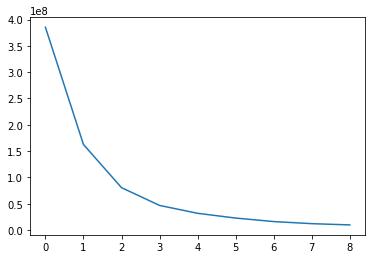

In [162]:
elb_list = []
for k in range(1,10):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(df[['BounceRates','Administrative_Duration']])
  elb_list.append(kmeans.inertia_)

plt.plot(elb_list)

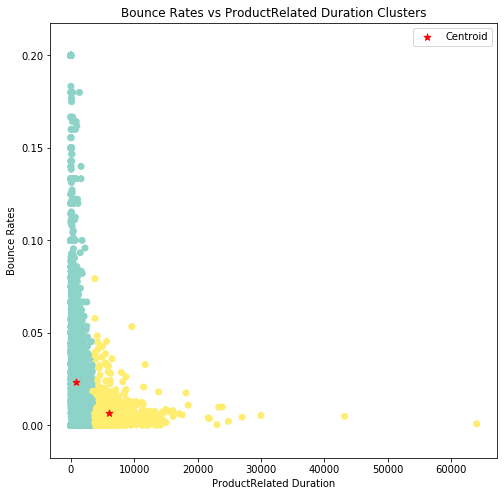

In [175]:
#df_cluster = df[['ProductRelated_Duration','BounceRates']].to_numpy()
kmeans = KMeans(n_clusters=2)
kmeans.fit(df[['BounceRates','ProductRelated_Duration']])
y_kmeans = kmeans.predict(df[['BounceRates','ProductRelated_Duration']])
plt.figure(figsize=(8,8))

plt.scatter(df['ProductRelated_Duration'],df['BounceRates'], c=y_kmeans, cmap='Set3')

#plt.scatter(df_cluster[y_kmeans == 0, 0], df_cluster[y_kmeans == 0, 1], c = 'pink', label = 'Un-interested Customers')
#plt.scatter(df_cluster[y_kmeans == 1, 0], df_cluster[y_kmeans == 1, 1], c = 'yellow', label = 'General Customers')
#plt.scatter(df_cluster[y_kmeans == 2, 0], df_cluster[y_kmeans == 2, 1], c = 'cyan', label = 'Target Customers')


plt.xlabel("ProductRelated Duration")
plt.ylabel("Bounce Rates")
plt.title("Bounce Rates vs ProductRelated Duration Clusters")

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1],centers[:, 0], c='red',s=50,marker='*',label="Centroid");
plt.legend()

While clustering using ProductRelated Duration, Users have been grouped into 2 clusters - Uniniterested Users and Target Users. Target users who spend approximately 5000 seconds or more in Product Related pages are more unlikely to bounce.

#### Informational Duration vs Bounce Rates Clustering

Elbow method to find the best value of K

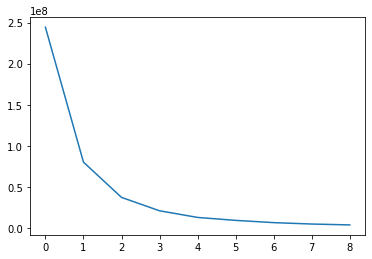

In [166]:
elb_list = []
for k in range(1,10):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(df[['BounceRates','Informational_Duration']])
  elb_list.append(kmeans.inertia_)

plt.plot(elb_list)


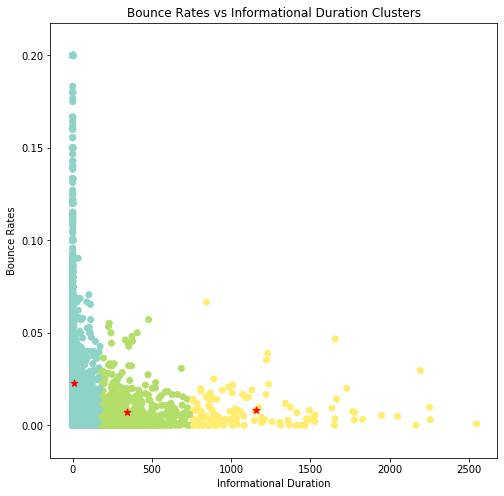

In [176]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['BounceRates','Informational_Duration']])
y_kmeans = kmeans.predict(df[['BounceRates','Informational_Duration']])
plt.figure(figsize=(8,8))

plt.scatter(df['Informational_Duration'],df['BounceRates'], c=y_kmeans, cmap='Set3')
plt.xlabel("Informational Duration")
plt.ylabel("Bounce Rates")
plt.title("Bounce Rates vs Informational Duration Clusters")
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1],centers[:, 0], c='red',s=50,marker='*');

Users can be clustered into Uniniterested Users, Casual Users and Target Users with K-Means Clustering.

We can clearly observe that customers who spend more than about 750 seconds on Informational pages are less likely to bounce.

### Converting Categorical Features to Integer

In [0]:
for i in range(0,len(df.columns)):
  if df.dtypes[i] == 'object':
    le = preprocessing.LabelEncoder()
    df[df.columns[i]] = le.fit_transform(df[df.columns[i]])
    #print(df[df.columns[i]])

In [35]:
df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,1,1,1,1,2,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,2,1,2,2,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,4,1,9,3,2,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,2,3,2,2,4,2,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,2,3,3,1,4,2,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,1,4,6,1,1,2,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,7,3,2,1,8,2,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,7,3,2,1,13,2,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,7,2,2,3,11,2,False,False


### Dealing with imbalanced data with SMOTE

In [0]:
X = df.drop(columns='Revenue')
y = df['Revenue']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) 

In [0]:
sm = SMOTE(random_state=2)

In [0]:
X_train_new,y_train_new = sm.fit_sample(X_train,y_train)

In [40]:
print("Number of True observations for 'Revenue' before SMOTE " + str(sum(y_train==True)))
print("Number of True observations for 'Revenue' after SMOTE " + str(sum(y_train_new==True)))

Number of True observations for 'Revenue' before SMOTE 1486
Number of True observations for 'Revenue' after SMOTE 8378


In [41]:
fig = go.Figure([go.Pie(labels=df['Revenue'].unique(),values=pd.Series(y_train).value_counts())])
fig.update_layout(title_text = "Number of True vs False Observations for 'Revenue' Before SMOTE",title_x =0.5)
fig.show()

In [42]:
fig = go.Figure([go.Pie(labels=df['Revenue'].unique(),values=pd.Series(y_train_new).value_counts())])
fig.update_layout(title_text = "Number of True vs False Observations for 'Revenue' After SMOTE",title_x =0.5)
fig.show()

### Scaling Data

Data is scaled because we are using some distance based algorithms such as Logistic Regression and K Nearest Neighbors which can benefit from scaling.



In [0]:
X_scaled = StandardScaler().fit_transform(X)

### Feature Selection

#### 1. Feature Selection Using Tree-Based Feature Importances



In [0]:
rf = RandomForestClassifier().fit(X_scaled,y)
model = SelectFromModel(rf,prefit=True,threshold='mean')
X_new_tree = model.transform(X)

In [0]:
selected_f = [X.columns[i] for i in range(0,len(model.get_support()-1)) if model.get_support()[i]==True]

In [46]:
f_importances = list(zip(X.columns,rf.feature_importances_))
f_importances.sort(key = lambda x: x[1],reverse=True) 
print([x[0] for x in f_importances])

['PageValues', 'ExitRates', 'ProductRelated_Duration', 'ProductRelated', 'BounceRates', 'Administrative_Duration', 'Administrative', 'Month', 'TrafficType', 'Region', 'Informational_Duration', 'Browser', 'OperatingSystems', 'Informational', 'VisitorType', 'Weekend', 'SpecialDay']


Text(0, 0.5, 'Features')

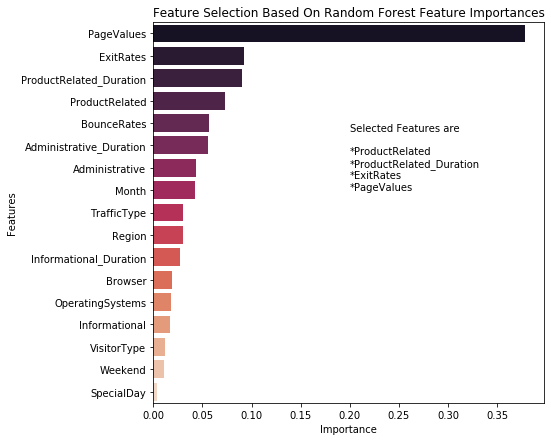

In [47]:
plt.figure(figsize=(7,7))
sns.barplot(y = [x[0] for x in f_importances], x = [x[1] for x in f_importances],palette="rocket")
plt.title("Feature Selection Based On Random Forest Feature Importances")
plt.text(0.2,7,"Selected Features are \n\n*" + "\n*".join(selected_f))
plt.xlabel("Importance")
plt.ylabel("Features")
#print((selected_f))

### Feature Selection using RFE

In [0]:
rfe = RFE(LogisticRegression()).fit(X_scaled,y)

In [0]:
selected_f = [X.columns[i] for i in range(0,len(rfe.support_)) if rfe.support_[i]==True]

In [0]:
X_new_rfe = rfe.transform(X)

In [51]:
f_importances = list(zip(X.columns,rfe.ranking_))
f_importances.sort(key = lambda x: x[1]) 
print([x[0] for x in f_importances])

['ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'VisitorType', 'OperatingSystems', 'Browser', 'Weekend', 'Informational', 'Region', 'TrafficType', 'Administrative_Duration', 'Informational_Duration', 'Administrative']


Text(0, 0.5, 'Features')

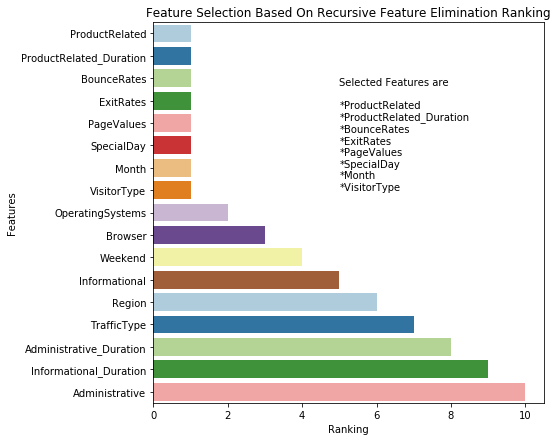

In [52]:
plt.figure(figsize=(7,7))
sns.barplot(y = [x[0] for x in f_importances], x = [x[1] for x in f_importances],palette="Paired")
plt.title("Feature Selection Based On Recursive Feature Elimination Ranking")
plt.text(5,7,"Selected Features are \n\n*" + "\n*".join(selected_f))
plt.xlabel("Ranking")
plt.ylabel("Features")
#print((selected_f))

### Model Selection

In [0]:
def train_and_plot(model_list,n,X):
  fig, axs = plt.subplots(2,figsize=(14,14))
  #plt.figure(figsize=(7,7))
  skf = StratifiedKFold(n_splits=n,shuffle=True)
  time_dict = {}  
  for model in model_list:
    print("\nBaseline Classification Report For " + str(model).split("(")[0])
    f1_arr,prec_arr,rec_arr,acc_arr = [],[],[],[]
    i=0
    t = time.process_time()
    for train_index, test_index in skf.split(X, y):
      i=i+1
      print(" Training " + str(model).split("(")[0] +" K - Fold Split "+str(i)+" ....")
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      X_train_new,y_train_new = sm.fit_sample(X_train,y_train)
      #model = SelectFromModel(model,prefit=True)
      #model = clone(model)
      model.fit(X_train_new,y_train_new)
      y_pred = model.predict(X_test)
      acc_arr.append(accuracy_score(y_test, y_pred))
      prec_arr.append(precision_score(y_test, y_pred))
      rec_arr.append(recall_score(y_test, y_pred))
      f1_arr.append(f1_score(y_test, y_pred))
      time_dict[str(model).split("(")[0]] = time.process_time()-t
    print("\nMean Accuracy")
    print(np.mean(acc_arr))
    print("Mean Precision")
    print(np.mean(prec_arr))
    print("Mean Recall")
    print(np.mean(rec_arr))
    print("Mean F1")
    print(np.mean(f1_arr))
    print("Time taken to train")
    #print("%0.2f" %(time.process_time()-t) + " seconds.")
    #print(time_dict)
    

    print("\nTraining Score "+ str(model.score(X_train_new,y_train_new)))
    print("Testing Score "+ str(model.score(X_test,y_test)))
    #print("\nTraining F-1 Score "+ str(f1_score(X_train_new,y_train_new)))
    #print("Testing F-1 Score "+ str(f1_score(X_test,y_test)))
    
    #print((classification_report(y_test,model.predict(X_test))))
    #plt.figure(2)
    print("\nConfusion Matrix\n")
    print(confusion_matrix(y_test,model.predict(X_test)))
    print("\n")
    #plt.show()
    #model.fit(X_train_new,y_train_new)
    #print("\n"+classification_report(y_test,model.predict(X_test)))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    
    axs[0].plot(fpr,tpr,label=str(model).split("(")[0] + " AUC : %0.2f " %(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
    #plt.fill_between(fpr,tpr)

  
  axs[0].set_xlabel("False Positive Rate")
  axs[0].set_ylabel("True Positive Rate")
  axs[0].set_xlim(0,1)
  axs[0].set_ylim(0,1)
  axs[0].set_title("ROC-AUC Graph")
  axs[0].legend()
  axs[0].plot([0, 1], [0, 1], 'k--')
  sns.barplot(x=pd.Series(time_dict).index,y=pd.Series(time_dict),ax=axs[1],palette="Blues_d")
  axs[1].set_xlabel("Algorithm")
  axs[1].set_ylabel("Time in seconds")
  axs[1].set_title("Training time for each model")




In [0]:
#modellist1 = [MLPClassifier(activation='logistic',solver='lbfgs')]
modellist = [LogisticRegression(),RandomForestClassifier(),DecisionTreeClassifier(),KNeighborsClassifier(),GaussianNB(),XGBClassifier()]


### Training with tree-based feature selection


Baseline Classification Report For LogisticRegression
 Training LogisticRegression K - Fold Split 1 ....
 Training LogisticRegression K - Fold Split 2 ....
 Training LogisticRegression K - Fold Split 3 ....
 Training LogisticRegression K - Fold Split 4 ....
 Training LogisticRegression K - Fold Split 5 ....
 Training LogisticRegression K - Fold Split 6 ....
 Training LogisticRegression K - Fold Split 7 ....
 Training LogisticRegression K - Fold Split 8 ....
 Training LogisticRegression K - Fold Split 9 ....
 Training LogisticRegression K - Fold Split 10 ....

Mean Accuracy
0.8746958637469586
Mean Precision
0.5746103347906362
Mean Recall
0.736351612014329
Mean F1
0.645081950298242
Time taken to train

Training Score 0.8277185501066098
Testing Score 0.8726682887266829

Confusion Matrix

[[941 101]
 [ 56 135]]



Baseline Classification Report For RandomForestClassifier
 Training RandomForestClassifier K - Fold Split 1 ....
 Training RandomForestClassifier K - Fold Split 2 ....
 Training

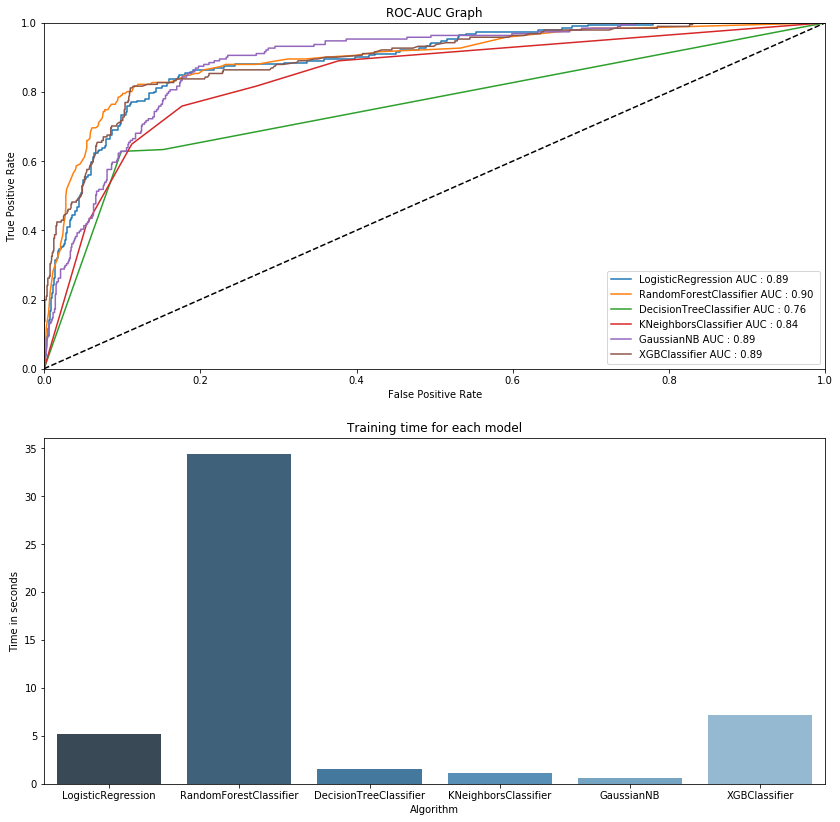

In [55]:
train_and_plot(modellist,10,X_new_tree)

### Training with Recursive Feature Elimination featureset


Baseline Classification Report For LogisticRegression
 Training LogisticRegression K - Fold Split 1 ....
 Training LogisticRegression K - Fold Split 2 ....
 Training LogisticRegression K - Fold Split 3 ....
 Training LogisticRegression K - Fold Split 4 ....
 Training LogisticRegression K - Fold Split 5 ....
 Training LogisticRegression K - Fold Split 6 ....
 Training LogisticRegression K - Fold Split 7 ....
 Training LogisticRegression K - Fold Split 8 ....
 Training LogisticRegression K - Fold Split 9 ....
 Training LogisticRegression K - Fold Split 10 ....

Mean Accuracy
0.8635036496350365
Mean Precision
0.5479089735214683
Mean Recall
0.7353623587765226
Mean F1
0.6266173060424368
Time taken to train

Training Score 0.8262793176972282
Testing Score 0.8637469586374696

Confusion Matrix

[[930 112]
 [ 56 135]]



Baseline Classification Report For RandomForestClassifier
 Training RandomForestClassifier K - Fold Split 1 ....
 Training RandomForestClassifier K - Fold Split 2 ....
 Traini

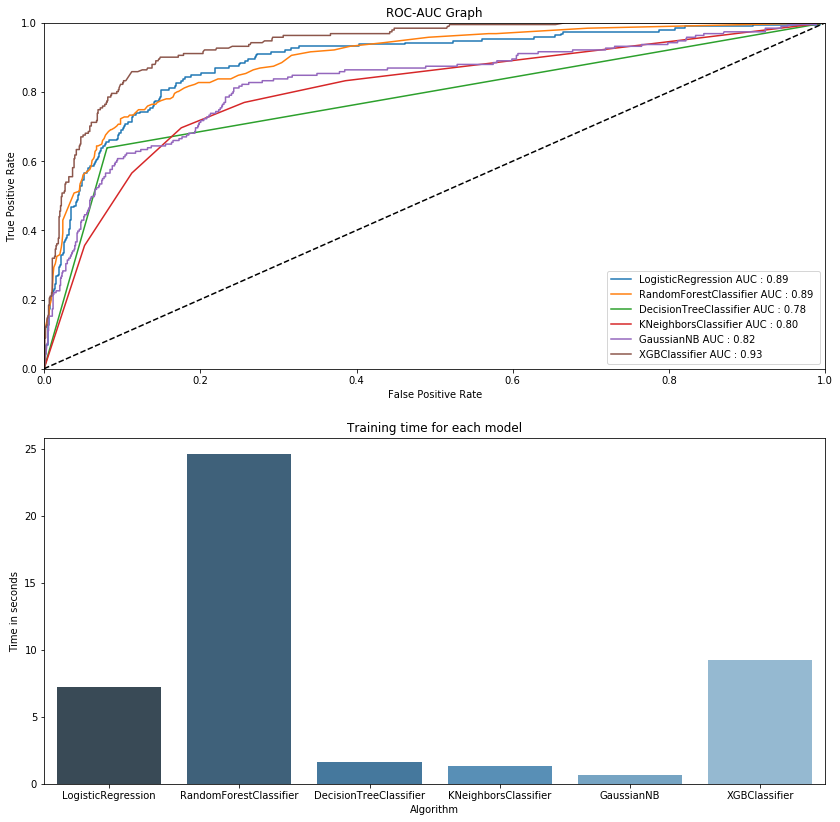

In [56]:
train_and_plot(modellist,10,X_new_rfe)

Base Model selection criteria: 


*   High F-1 Score
*   High AUC-ROC Score
*   High Recall Score
*   Low Bias and Variance
*   Low Runtime

XGBoostClassifier with featureset derived from Recursive Feature Elimination satisfies the model selection criteria.


### Hyperparameter Tuning

In [0]:
final_model = XGBClassifier()

In [0]:
param_grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [0]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

clf = RandomizedSearchCV(final_model, param_grid, cv=10, verbose=1,scoring='roc_auc')


In [0]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_new_rfe, y, test_size = 0.2, random_state = 0) 

In [61]:
best_model = clf.fit(X_train_final, y_train_final)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   58.5s finished


In [62]:
print(f1_score(y_test_final,best_model.best_estimator_.predict(X_test_final)))

0.6401062416998672


In [63]:
print(accuracy_score(y_test_final,best_model.best_estimator_.predict(X_test_final)))

0.8901054339010543


In [64]:
print(roc_auc_score(y_test_final,best_model.best_estimator_.predict_proba(X_test_final)[:,1]))

0.9247618738464677


In [65]:
best_model.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.1,
 'learning_rate': 0.25,
 'max_depth': 3,
 'min_child_weight': 5}

Interpreting model coefficients (Variable Importances in this case since we are using a tree-based model).

In [66]:
list(zip(selected_f,best_model.best_estimator_.feature_importances_))

[('ProductRelated', 0.046010938),
 ('ProductRelated_Duration', 0.043973308),
 ('BounceRates', 0.04627108),
 ('ExitRates', 0.067161895),
 ('PageValues', 0.6157007),
 ('SpecialDay', 0.03546005),
 ('Month', 0.088832155),
 ('VisitorType', 0.056589793)]

## Conclusions



1.   The most 'informative' variable for determining the occurence of a sale is 'PageValues'.
2.   Spending more time on Product Related pages raises chance of buying an item.
3.   ProductRelated pages have the highest page value compared to Administrative and Informational.
4.  The XGBoost algorithm has performed the best and the fastest (Speed has been accounted for because we need a scalable solution).






